In [14]:
import copy
import os
import random
import uuid
from dataclasses import asdict, dataclass
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt

import yaml
import gymnasium as gym
import numpy as np
import pyrallis
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import sys
sys.path.append('../scripts')
import pickle
from tensordict import MemoryMappedTensor, TensorDict
from iql_debug import ImplicitQLearning, TwinQ, ActorNet
from utils import *

In [15]:
%matplotlib widget

In [16]:
checkpoints_path = "/home/lucas/Workspace/CORL/out"
run_name = "IQL-evasion-v1-8bf20e7c"
model_dict = torch.load(os.path.join(checkpoints_path, run_name, "checkpoint_IQL.pt"))

In [17]:
with open(os.path.join(checkpoints_path, run_name, "config.yaml"),"r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [18]:
# Set environment parameters.
img_size = config['env']['img_size']
time_max = config['env']['max_time_step']
observation_img_size = [1, img_size, img_size]
map_size = config['env']['map_size']

action_dim = 1
action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(action_dim,))

if config['env']['observation']['goal_direction_normalized']:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-1, 1, shape=(2,)),
                            'time_spent': gym.spaces.Box(low=1.0, high=np.inf, shape=(1,))})
else:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-map_size / 2.0, map_size / 2.0, shape=(2,)),
                            'time_spent': gym.spaces.Box(low=1.0, high=np.inf, shape=(1,))})

In [19]:
model_dict

{'qf': OrderedDict([('feature_extractor.extractors.heat_map.cnn.0.weight',
               tensor([[[[ 0.0929, -0.0444, -0.0924,  ..., -0.3523, -0.3845, -0.6021],
                         [-0.0757,  0.0675, -0.1577,  ..., -0.3235, -0.4153, -0.5800],
                         [ 0.0290,  0.0241, -0.0412,  ..., -0.2609, -0.2707, -0.3838],
                         ...,
                         [ 0.0579,  0.1637, -0.0123,  ..., -0.2229, -0.2154, -0.3688],
                         [ 0.2451,  0.1698, -0.0726,  ..., -0.1618, -0.3193, -0.4377],
                         [ 0.2099,  0.1087,  0.0430,  ..., -0.1239, -0.3469, -0.4317]]],
               
               
                       [[[-0.0710,  0.0846, -0.0758,  ..., -0.1447, -0.0302, -0.1055],
                         [ 0.1392,  0.1321, -0.0274,  ..., -0.1124, -0.0019, -0.1754],
                         [-0.0656,  0.1203,  0.0736,  ..., -0.0063, -0.0154, -0.1236],
                         ...,
                         [-0.0996, -0.0750, -0.0

### Load Actor ###

In [20]:
if config['policy']['hidden_act'] == 'Tanh':
    actor = ActorNet(observation_space, action_space, config['policy']['actor_net_hidden'], hidden_act=nn.Tanh)
else:
    print("Activation function does not match.")
actor.load_state_dict(model_dict['actor'])
actor.eval()

ActorNet(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (time_spent): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (policy_net): Sequential(
    (0): Linear(in_features=259, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
)

### Load Q function ###

In [21]:
q_network = TwinQ(observation_space, action_dim)
q_network.load_state_dict(model_dict['qf'])
q_network.eval()

TwinQ(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (time_spent): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (q1): MLP(
    (net): Sequential(
      (0): Linear(in_features=260, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
      (5): Squeeze()
    )


### Load one of the training data ###

In [26]:
delta_t = config['env']['delta_t']
V = config['env']['V']
radar_radius = config['env']['radar_radius']
aircraft_detection_range = config['env']['aircraft_detection_range']
grid_size=2*aircraft_detection_range/img_size

time_scaling = config['env']['observation']['time_scaling']
action_resclae = config['policy']['action_scale']
goal_torl = config['env']['goal_tolerance']

data_path = "/home/lucas/Workspace/evasion_guidance/evasion_guidance/data/"

In [31]:
episode_idx = 50
episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()

state_cur = episode_dict['start_state']
radar_locs = episode_dict['radar_locations']
radar_orientations = episode_dict['radar_orientations']
goal_location = episode_dict['goal_location']


time_spent = 0

trajectory = [state_cur]
q_values = []
with torch.no_grad():
    while np.linalg.norm(state_cur[:2] - goal_location) > goal_torl:
        print("Time spent: ", time_spent)
        if time_spent > config['env']['max_time_step']:
            print("Reached time limit.")
            break
        obs = TensorDict({
            'heat_map': torch.from_numpy(get_radar_heat_map(state_cur, radar_locs, img_size,
                                           aircraft_detection_range,
                                           grid_size, 
                                           radar_radius)).unsqueeze(dim=0).float(),
            'goal_direction': torch.from_numpy((goal_location - state_cur[:2]) / (map_size / 2)).unsqueeze(dim=0).float(),
            'time_spent': torch.from_numpy(np.asarray([np.exp(time_spent/time_scaling)])).unsqueeze(dim=0).float()
        })
        # print(obs)
        # print("State: ", state_cur)
        u, _ = actor(obs)
        # print(q_network(obs, u))
        u = action_resclae*u
        state_cur = state_cur + delta_t*np.array([V*np.cos(state_cur[2]), V*np.sin(state_cur[2]), u.flatten().numpy()[0]/V])
        # print(state_cur)
        time_spent += 1
        trajectory.append(state_cur)
        q_values.append(q_network(obs, u).cpu().numpy()[0])
trajectory = np.asarray(trajectory)
q_values = np.asarray(q_values)

Time spent:  0
Time spent:  1
Time spent:  2
Time spent:  3
Time spent:  4
Time spent:  5
Time spent:  6
Time spent:  7
Time spent:  8
Time spent:  9
Time spent:  10
Time spent:  11
Time spent:  12
Time spent:  13
Time spent:  14
Time spent:  15
Time spent:  16
Time spent:  17
Time spent:  18
Time spent:  19
Time spent:  20
Time spent:  21
Time spent:  22
Time spent:  23
Time spent:  24
Time spent:  25
Time spent:  26
Time spent:  27
Time spent:  28
Time spent:  29
Time spent:  30
Time spent:  31
Time spent:  32
Time spent:  33
Time spent:  34
Time spent:  35
Time spent:  36
Time spent:  37
Time spent:  38
Time spent:  39
Time spent:  40
Time spent:  41
Time spent:  42
Time spent:  43
Time spent:  44
Time spent:  45
Time spent:  46
Time spent:  47
Time spent:  48
Time spent:  49
Time spent:  50
Time spent:  51
Time spent:  52
Time spent:  53
Time spent:  54
Time spent:  55
Time spent:  56
Time spent:  57
Time spent:  58
Time spent:  59
Time spent:  60
Time spent:  61
Time spent:  62
Ti

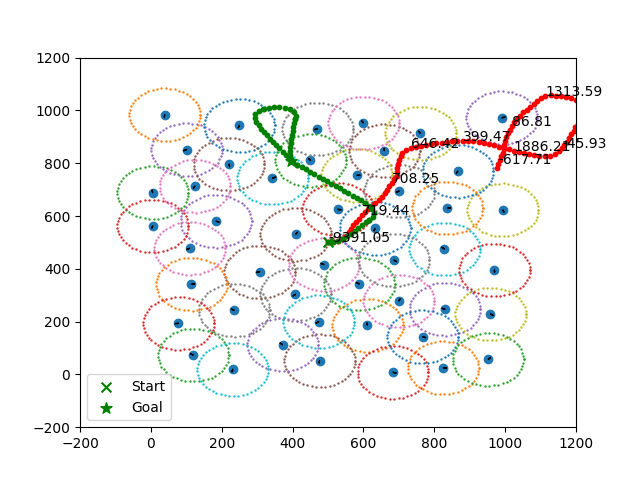

In [32]:
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radar_orientations, radius=radar_radius, xlim=[0, map_size], ylim=[0, map_size])


ax.scatter(trajectory[:, 0], trajectory[:, 1], s=10, c='r')
ax.scatter(episode_dict['state_history'][:, 0], episode_dict['state_history'][:, 1], s=10, c='g')
for i, q_val in enumerate(q_values):
    if i % 10 == 0:
        ax.annotate(int(100*q_val)/100, (trajectory[i, 0], trajectory[i, 1]))
ax.scatter(episode_dict['start_state'][0], episode_dict['start_state'][1], s=50, c='g', marker='x', label="Start")
ax.scatter(goal_location[0], goal_location[1], s=70, c='g', marker='*', label='Goal')

ax.set_xlim(-200, 1.2*map_size)
ax.set_ylim(-200, 1.2*map_size)
ax.legend()
plt.show()